# Interaction

There are two ways to interact with Dynamiks:

1. Make your own custom time-stepping loop and add the interaction in the loop
2. Use Dynamiks' time-stepping loop and interact via step handlers

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation
from dynamiks.dwm.particle_motion_models import ParticleMotionModel, XSpeed
from dynamiks.visualizers import ParticleVisualizer
from dynamiks.visualizers.flow_visualizers import Flow2DVisualizer
from dynamiks.utils.data_dumper import DataDumper
from dynamiks.views import YView, EastNorthView, XYView
from py_wake.utils.plotting import setup_plot

## Custom time-stepping loop

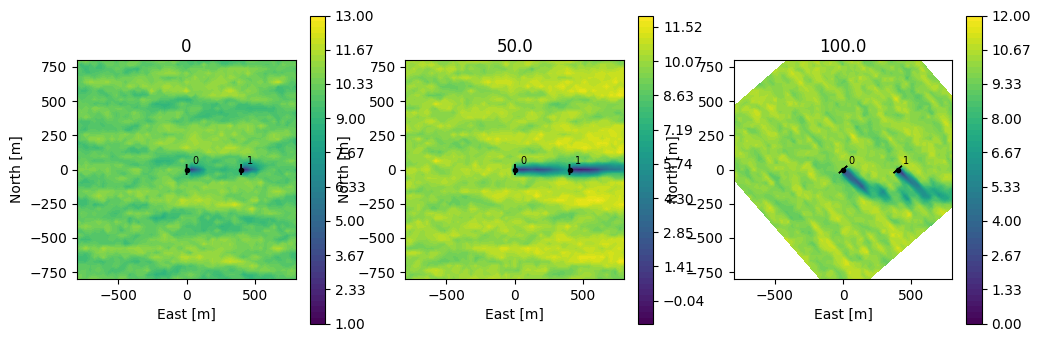

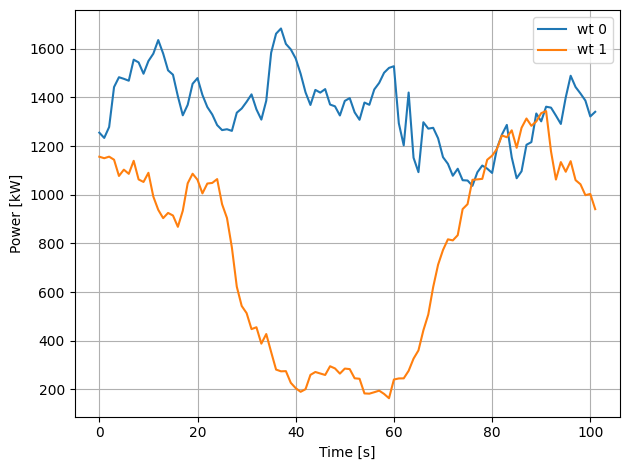

In [2]:
fs = DefaultDWMFlowSimulation(x=[0,400],y=[0,0], ti=.05)

data = []
u_lst=[]
power_lst = []
wd_lst = []
time_lst = range(0,102)

axes = plt.subplots(1,3, figsize=(12,4))[1]
for t in time_lst: # custom time-stepping loop
    fs.run(t)  # step dynamiks

    # plot the flow field every 50s
    if t%50==0:        
        view=EastNorthView(z=70, x=np.linspace(-800,800), y=np.linspace(-800,800),ax=axes[t//50])
        fs.show(view, block=False)
        
    # change wind direction one deg per time step
    if t>50:
        fs.wind_direction +=1

    power_lst.append(fs.windTurbines.power()/1000)
    
da = xr.DataArray(power_lst, coords={'time':time_lst, 'wt':[0,1]})
plt.figure()
for wt in da.wt:
    da.sel(wt=wt).plot(label=f'wt {wt.item()}')
setup_plot(xlabel='Time [s]', ylabel='Power [kW]', title='')

## Step handlers
Step handlers are functions that is executed in the end of Dynamiks' time-stepping loop.

```python
# dynamiks time-stepping loop
while fs.time<time_stop:
    fs.time+=dt
    ...
    for step_handler in self.step_handlers:
        step_handler(self)
```

Step handlers must take `flowSimulation`-object as input, `f(flowSimulation) -> None`

An example of a function that appends the time and u component to a list, as we also did above

In [3]:
def plot_flow(flowSimulation):
    view=EastNorthView(z=70, x=np.linspace(-800,800), y=np.linspace(-800,800),flowVisualizer=Flow2DVisualizer(color_bar=False),
                       ax=plt.gcf().axes[int(flowSimulation.time//50)])
    flowSimulation.show(view, block=False, )

another example is a function that changes the wind direction, as we also did above

In [4]:
def wd_changer(fs):
    fs.wind_direction+=1

### DataDumpers
The `DataDumper` class is a special kind of step handlers. It appends data to a list, similar to the `u_lst_dumper` example above, but it has a function to export the data to a xarray dataset.

`DataDumper` takes a function, `f(flowSimulation) -> data` and an optionally dictionary with the coordinates of the data

In [5]:
def get_power(fs): # f(flowSimulation) -> (power_wt1, power_wt2)
    return fs.windTurbines.power()/1000

power_dumper = DataDumper(get_power, 
                          coords={'wt':[0,1]}) # coordinates of first axis                                 

### Specifying step handlers
The `FlowSimulation` class takes a list of step handlers as input

```python
fs = FlowSimulation(..., step_handlers=[my_step_handler1, my_step_handler2])
```

Alternatively, step handlers, can be appended afterwards:

```python
fs = FlowSimulation(...)
fs.step_handlers.append(my_step_handler3)
```


##### Custom `start` and `step`

It is possible to specify a custom start time and step time for the step handlers like this:

```python
step_handlers=[my_step_handler1,          # executes every time step
               ((10,5), my_step_handler2) # executes every 5th second after the first 10s, i.e. [15,20,...]
               ]
```

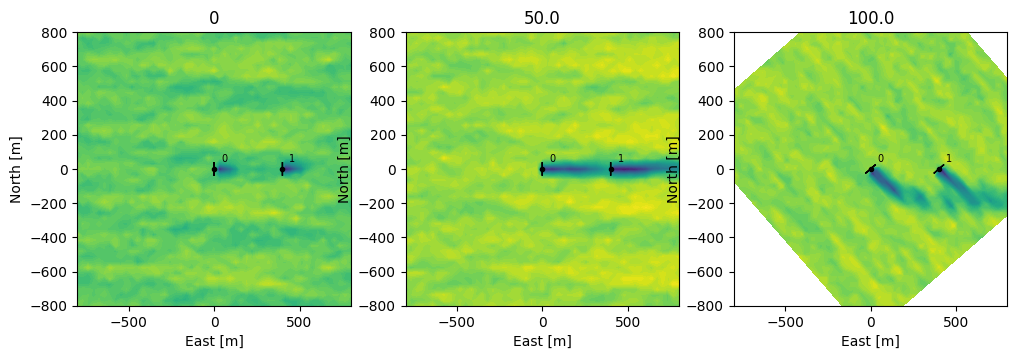

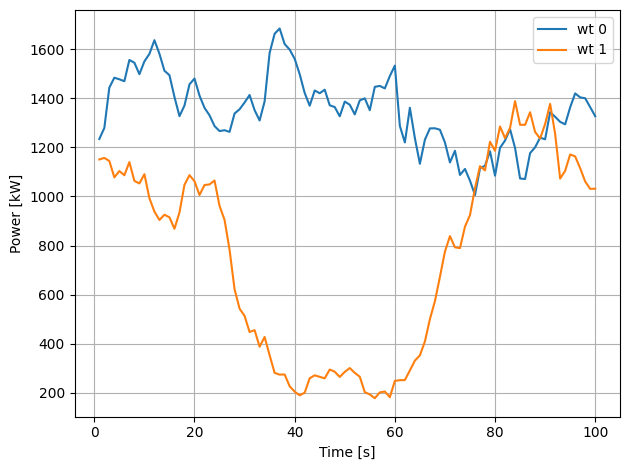

In [6]:
axes = plt.subplots(1,3, figsize=(12,6))[1]
fs = DefaultDWMFlowSimulation(x=[0,400],y=[0,0], ti=.05,
                              step_handlers=[((0,50), plot_flow),
                                             power_dumper,
                                             ((50,1), wd_changer)])
plot_flow(fs) # plot flow of t=0
fs.run(100) # run dynamiks time-stepping loop

da = power_dumper.to_xarray()
plt.figure()
for wt in da.wt:
    da.sel(wt=wt).plot(label=f'wt {wt.item()}')
setup_plot(xlabel='Time [s]', ylabel='Power [kW]', title='')